In [1]:
import os
import shutil
import unittest
from catvae.trainer import LightningCountVAE
from catvae.sim import multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import argparse
import seaborn as sns

In [2]:
import torch
torch.__version__

'1.7.0.dev20200828'

# Simulate data

In [3]:
np.random.seed(0)
k = 10
sims = multinomial_bioms(k=k, D=50, N=250, M=100000)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

In [4]:
sims['tree'].write('basis.nwk')

'basis.nwk'

# Train model

In [5]:
output_dir = 'output'
args = [
    '--train-biom', 'train.biom',
    '--test-biom', 'train.biom',
    '--val-biom', 'train.biom',
    '--basis-file', 'basis.nwk',
    '--output-directory', output_dir,
    '--epochs', '5000',
    '--batch-size', '200',
    '--num-workers', '10',
    '--scheduler', 'steplr',
    '--learning-rate', '1e-3',
    '--n-latent', str(k),
    '--gpus', '1'
]
parser = argparse.ArgumentParser(add_help=False)
parser = LightningCountVAE.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningCountVAE(args)
model.set_eigs(sims['eigvectors'], sims['eigs'])

trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=10,
    # profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type         | Params
---------------------------------------
0 | model | LinearCatVAE | 10 K  


Exception ignored in: <function _releaseLock at 0x7fb9e133dee0>
Traceback (most recent call last):
  File "/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


1

In [6]:
%load_ext tensorboard

In [7]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 5284), started 8:02:26 ago. (Use '!kill 5284' to kill it.)

In [8]:
trainer.model

LightningCountVAE(
  (model): LinearCatVAE(
    (encoder): Linear(in_features=49, out_features=10, bias=False)
    (decoder): Linear(in_features=10, out_features=49, bias=False)
  )
)

# Evaluate the model

In [26]:
!ls lightning_logs/version_11/checkpoints

'epoch=4029.ckpt'


In [27]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_dir = 'lightning_logs/version_11/checkpoints'
path = f'{checkpoint_dir}/epoch=4029.ckpt'
model = LightningCountVAE.load_from_checkpoint(path).cuda()

(0.9640070814997697, 0.0)


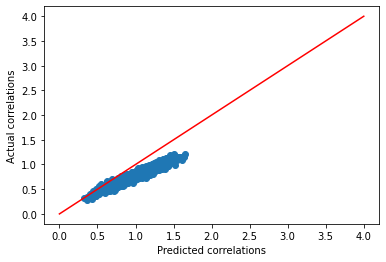

In [28]:
#W = model.model.get_loadings()
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.model.decoder.weight.detach().cpu().numpy()

d_estW = pdist(W)
dW = pdist(sims['W'])
# we appear to be off by a factor of 2 -- where is this coming from?
plt.scatter(dW, d_estW)
plt.plot(np.linspace(0, 4), np.linspace(0, 4), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

In [29]:
np.diag(sims['W'].T @ sims['W'])

array([0.01      , 0.55333333, 1.09666667, 1.64      , 2.18333333,
       2.72666667, 3.27      , 3.81333333, 4.35666667, 4.9       ])

In [30]:
np.diag(W.T @ W)

array([1.342421 , 2.3882096, 2.069976 , 1.7636508, 1.0477492, 1.2688235,
       1.8997023, 0.3664625, 0.5818335, 2.1953387], dtype=float32)

In [31]:
eigvals = (W**2).sum(axis=0)
Weig = W / np.sqrt(eigvals)

In [42]:
np.round(Weig.T @ Weig, 2)

array([[ 1.  , -0.  ,  0.  , -0.01,  0.03,  0.02,  0.01,  0.  ,  0.  ,
         0.  ],
       [-0.  ,  1.  ,  0.02,  0.01, -0.01, -0.04, -0.05, -0.01, -0.01,
         0.01],
       [ 0.  ,  0.02,  1.  ,  0.01,  0.  ,  0.01,  0.07,  0.  ,  0.  ,
         0.01],
       [-0.01,  0.01,  0.01,  1.  , -0.02, -0.04, -0.02, -0.  , -0.  ,
        -0.02],
       [ 0.03, -0.01,  0.  , -0.02,  1.  ,  0.05,  0.  ,  0.01,  0.01,
        -0.01],
       [ 0.02, -0.04,  0.01, -0.04,  0.05,  1.  ,  0.02, -0.  ,  0.01,
        -0.  ],
       [ 0.01, -0.05,  0.07, -0.02,  0.  ,  0.02,  1.  ,  0.  ,  0.  ,
        -0.03],
       [ 0.  , -0.01,  0.  , -0.  ,  0.01, -0.  ,  0.  ,  1.  ,  0.02,
        -0.  ],
       [ 0.  , -0.01,  0.  , -0.  ,  0.01,  0.01,  0.  ,  0.02,  1.  ,
        -0.01],
       [ 0.  ,  0.01,  0.01, -0.02, -0.01, -0.  , -0.03, -0.  , -0.01,
         1.  ]], dtype=float32)

In [33]:
Wu, Ws, Wv = np.linalg.svd(W)
k = W.shape[1]
Wu = Wu[:, :k]
Ws = Ws[:k]
Wv = Wv[:k, :]

In [34]:
np.linalg.norm(Weig.T @ Weig - np.eye(Weig.shape[-1]))

0.19592594006875005

In [35]:
Ws

array([1.5558598 , 1.4863396 , 1.4639281 , 1.3516681 , 1.3164084 ,
       1.1640483 , 1.1204909 , 1.0163673 , 0.76279336, 0.6048757 ],
      dtype=float32)

In [36]:
eigvals = np.sqrt(np.sort(eigvals)[::-1])

In [37]:
np.sqrt(np.sum((eigvals - Ws)**2))

0.04155749

In [38]:
sims['sigma']

0.31622776601683794

In [39]:
torch.exp(model.model.log_sigma_sq)

tensor(0.0760, device='cuda:0', grad_fn=<ExpBackward>)

In [40]:
model.model.log_sigma_sq

Parameter containing:
tensor(-2.5769, device='cuda:0', requires_grad=True)